# Determining the Effect of Earlier Weaning off Mechanical Ventilation
This project aims to use causal inference to estimate the effects of weaning patients off mechanical ventilation sooner than normal, following the approach described in [Kennedy, 2018](https://arxiv.org/pdf/1704.00211.pdf). In our dataset we consider patients who have been on mechanical ventilation for 24 hours (our start criteria).

In [ ]:
import pickle

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler

# ALL_WEANING_PREDICTORS is a list of all covariates intially identified as potentially useful in predicting probability of weaning
# group_by_stay is a helper function that groups a dataframe by the column 'stay_id'
from common import (
    ALL_WEANING_PREDICTORS,
    create_calibration_curve,
    group_by_stay,
    remove_extremes,
    remove_outliers
)

np.random.seed(0)

First, we exclude variables from consideration if they are missing more than 10% of the time in post-baseline times. Post-baseline in this case means we filter out records from patients at time points before our start criteria.

```
>>> full_df = pd.read_csv('full_weaning_dataset.csv')
>>> post_baseline_df = full_df.loc[full_df['hour_baseline'] >= 0]
```
We sample a subset of patiets from this post-baseline dataframe and use that as our dataset for this notebook.
```
>>> stay_ids = post_baseline_df['stay_id'].unique()
>>> print(len(stay_ids))
8055
```
Get a random sample of about 5% of the stay_ids.
```
>>> stays = np.random.choice(stay_ids, size=500)
>>> sampled_df = post_baseline_df.loc[post_baseline_df['stay_id'].isin(stays)]
>>> sampled_df.to_csv('sampled_post_baseline.csv')
```

In [2]:
# Load in the sampled dataset
df = pd.read_csv('sampled_post_baseline.csv')

In [2]:
df = pd.read_csv('post_baseline_weaning.csv')

/Users/aman/VSCode Files/earlier-mv-weaning/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (474) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Before testing which variables are missing, we fill missing urine output (`urine_output`) and vasopressor (`rate_std`) values with 0, since missing entries for these two columns means the value is 0 in this dataset. We do this to make sure we don't exclude the columns from the dataset when we shouldn't.

In [3]:
df.loc[:, ['urine_output', 'rate_std']] = df[['urine_output', 'rate_std']].fillna(0)

Then, we forward fill all columns except for `amount` on a per-patient basis. Their values may only be measured occasionally, which is fine since the previous measurement of these values is important, not whether they were measured recently.

In [4]:
for c in ALL_WEANING_PREDICTORS:
    if c == 'amount': continue
    df.loc[:, c] = group_by_stay(df, c).ffill()

In [5]:
LEN_DF = len(df)
cols_to_exclude = set()
for c in ALL_WEANING_PREDICTORS:
    na_proportion = df[c].isna().sum() / LEN_DF
    if na_proportion >= 0.1:
        cols_to_exclude.add(c)
        print(f"{c}: {round(na_proportion, 3)}")

fio2: 0.233
carboxyhemoglobin: 0.958
methemoglobin: 0.962
ALBUMIN: 0.233
BANDS: 0.652
BILIRUBIN: 0.135
marital_status: 0.115


Now that we've identified which columns should be excluded from our analysis, we can create a new list of predictors.

In [6]:
weaning_predictors = [c for c in ALL_WEANING_PREDICTORS if c not in cols_to_exclude]

# If a column for the measurement of a given value at time t-1 exists, add it to the predictors
for c in weaning_predictors:
    try:
        df['last_' + c]
        weaning_predictors.append('last_' + c)
    except KeyError:
        pass

The next step is to process the data and remove outliers. The `remove_outliers` function essentially writes over implausible values with NaN.

In [7]:
df.loc[:, 'amount'] = df['amount']/1000
df.loc[:, 'last_amount'] = df['last_amount']/1000

remove_outliers(df)

Now, we'll standardize our predictors.

In [8]:
# Standardize predictors
numeric = df[weaning_predictors].select_dtypes(exclude='object').columns
df.loc[:, numeric] = StandardScaler().fit_transform(df[numeric])
# Sanity check to make sure the DataFrame was actually standardized
df[numeric].agg(['mean', 'std'])

,tidal_volume_set,tidal_volume_observed,plateau_pressure,ventilator_type,peep_set,total_peep_level,peak_insp_pressure,mean_airway_pressure,inspiratory_time,spo2,...,last_CREATININE,last_PLATELET,last_PTT,last_INR,last_PT,last_BUN,last_WBC,last_urine_output,last_GLUCOSE,last_weight
mean,-5.608631e-16,-8.375239e-17,-8.543197e-17,5.268912e-17,-2.289835e-19,-1.458428e-15,6.524109e-16,9.348858e-17,8.788456e-16,2.727498e-15,...,8.830201e-17,-1.559713e-16,-8.908608e-16,-2.936658e-16,-5.879989e-16,-1.969496e-17,-3.726353e-16,3.702949e-17,3.983551e-16,-1.154717e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


Before modeling the probability of weaning, we'll impute medians and remove extreme values from the covariates.

In [9]:
for c in numeric:
    df.loc[:, c].fillna(df[c].median(), inplace=True)

remove_extremes(df)

The final step before modeling is to define our training data. Since we're interested in predicting the probability of starting the first weaning attempt, the relevant data is every timestep up until and including the true start of the first weaning attempt.

In [12]:
num_days_off_ctrl = group_by_stay(df, 'control').transform(
    lambda x: (x == 0).cumsum()
)
df = df.loc[num_days_off_ctrl <= 1]

In [13]:
MODEL_PARAMS = {
    'penalty': 'l2',
    'max_iter': 2000,
}
X = df[weaning_predictors]
y = df['control']

for col in X.select_dtypes(include='object'):
    X.loc[:, col] = LabelEncoder().fit_transform(X[col])

In [14]:
weaning_predictor = LogisticRegression(**MODEL_PARAMS).fit(X, y)
"""
with open('weaning_predictor.pkl', 'wb') as f:
    pickle.dump(weaning_predictor, f)
"""

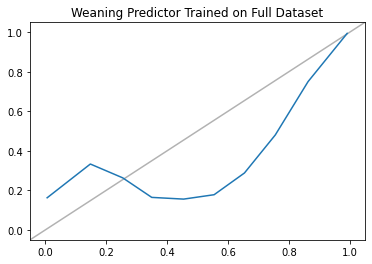

In [15]:
with open('weaning_predictor.pkl', 'rb') as f:
    weaning_predictor = pickle.load(f)

create_calibration_curve(
    weaning_predictor, X, y,
    'Weaning Predictor Trained on Full Dataset',
    save_path='images/full_dataset_calibration_curve.png'
)

Train a calibrated regressor since the above graph shows that the current predictor is poorly calibrated.

In [16]:
calibrated_predictor = CalibratedClassifierCV(base_estimator=LogisticRegression(**MODEL_PARAMS), method='isotonic').fit(X, y)
"""
with open('calibrated_predictor.pkl', 'wb') as f:
    pickle.dump(calibrated_predictor, f)
"""

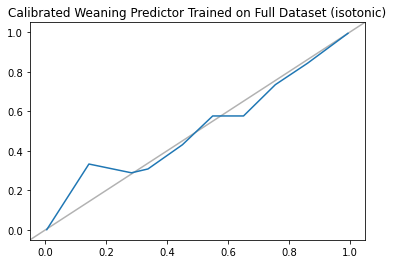

In [19]:
with open('calibrated_predictor.pkl', 'rb') as f:
    calibrated_predictor = pickle.load(f)

create_calibration_curve(
    calibrated_predictor, X, y, 
    'Weaning Predictor with Isotonic Calibration (full dataset)',
    save_path='images/isotonic_calibration_curve.png'
)

With our well-calibrated model for the probability of weaning, we can now estimate the causal effect of incrementing this propensity score.

In [ ]:
# for each value of delta:

# 1. construct time-dependent weights W_t for each subject and timepoint
# 2. calculate cumulative product weight for each subject across timepoints
# 3. compute phi for each subject by multiplying this cumulative weight by the outcome
# 4. estimator is the average of phi across subjects.

df.loc[:, 'propensity_score'] = calibrated_predictor.predict_proba(X)

results = {}

for delta in np.arange(0.5, 2, 0.1):
    A = df['control']
    pi_hat = df['propensity_score']
    # construct time-dependent weights for each subject at each timepoint
    df.loc[:, 'weights'] = (
        ((delta * A) + 1 - A) /
        ((delta * pi_hat) + 1 - pi_hat)
    )
    # calculate cumulative product of weights
    cumulative_products = group_by_stay(df, 'weights').prod()
    # multiply by outcome
    phi = cumulative_products.multiply(
        group_by_stay(df, 'hospital_expire_flag').first()
    )
    # average over subjects and add to results
    results[delta] = phi.mean()